# Lab 3 : Feature selection

This lab is about selectiing the most relevant features of the dataset, which will allow to reduce its dimensonality. In our case, dimensionality reduction can prove itself to be very useful as the dataset is pretty heavy : the training set has 2870 samples, each having 255 by 255 features (pixels). 
Therefore, it can be computationally expensive to process all the information. 
Besides, it is not unusual that a classifier produces better results with a reduced dataset, as some features add noise to the data and represent also more infomation to retain and process.

In [21]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB


# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Data Loading 

This step loads the images contained in the training dataset.

In [2]:
def process_image(img, size, grey_scale=True):
    '''
    This function reduces the size of the image and converts 
    it to a grey_scale image.
    '''
    img = cv2.resize(img, size)
    if grey_scale:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/size[0]
    return img

### Train Dataset

In [3]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
train_labels = [] #label of each image in x_train 
PATH = 'archive/Training'
new_size = (255, 255)

for label in labels:
    img_dir = os.path.join(PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        img = process_image(img, new_size)
        train_img.append(img)
        train_labels.append(label)
        
train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)

train_img shape :  (2870, 255, 255)


### Test Dataset

In [4]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
test_img = [] #contains the images used for testing the model
test_labels = [] #label of each image in test_img
PATH = 'archive/Testing'
new_size = (255, 255)

for label in labels:
    img_dir = os.path.join(PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        img = process_image(img, new_size)
        test_img.append(img)
        test_labels.append(label)
        
test_img = np.stack(test_img)
test_labels = np.stack(test_labels)

print("test_img shape : ", test_img.shape)

test_img shape :  (394, 255, 255)


## Convert Brain Tumor classes to numerical values

In [5]:
class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])
test_labels = np.array([class_map[label] for label in test_labels])

## Reduced dataset creation : 300 samples per class

Some methods used in the following sections to extract features are computationally expensive and can cause some memory allocation issues. We arbitrary choose to reduce the dataset to 300 samples per classe. In other labs, we will try to increase this number as much as possible to utilize all the data. 

In [6]:
list_index = []

no_tumor_index = np.where(train_labels == 0)[0][0]
list_index.append(no_tumor_index)

glioma_index = np.where(train_labels == 1)[0][0]
list_index.append(glioma_index)

pituitary_index = np.where(train_labels == 2)[0][0]
list_index.append(pituitary_index)

meningioma_index = np.where(train_labels == 3)[0][0]
list_index.append(meningioma_index)

x = []
y = []
for ind in list_index:
    x.append(train_img[ind : ind+300])
    y.append(train_labels[ind : ind + 300])


flat_x = np.stack(x)
flat_x = flat_x.reshape((flat_x.shape[0]*flat_x.shape[1], 255*255))

flat_y = np.stack(y)
flat_y = flat_y.reshape((flat_y.shape[0]*flat_y.shape[1]))

print("dataset shape : ", flat_x.shape)

dataset shape :  (1200, 65025)


### Feature Ranking

We would use a dictionary to store the rankings of features from each feature selection algortihm

In [7]:
rankings = dict()

## Feature Selection



### Dimensionality reduction by PCA 

PCA enables to extract a specific number of features while conserving an acceptable amount of information (variance) from original features . 
It consists in projecting the original dataset (standardized) in a less dimensional space such that its variance is maximized, given by the formula : $X_{pca} = X_{original}.W$, the number of W columns corresponding to the number of extracted features.
The first component is : 

$$w_{1} = \underset{||w||=1}{argmax}\Bigg\{||Xw||^{2}\Bigg\} = \underset{w}{argmax}\Bigg\{\frac{w^{T}X^{T}Xw}{w^{T}w}\Bigg\} $$


Other W components are obtained by first computing the substraction of $k-1$ PC:
$$\hat{X}_{k} = X -  \sum \limits_{j=1}^{k-1} Xw_{j}w_{j}^{T}$$

And then by computing : 

$$w_{k} = \underset{w}{argmax}\Bigg\{\frac{w^{T}\hat{X}_{k}^{T}\hat{X}_{k}w}{w^{T}w}\Bigg\}$$

In practice, this problem is a Singular Values Decomposition one, as it implies finding the eigen values of the Covariance matrix (up to a factor) $X^{T}X$ .

Note that we have to standardize (substract mean and divide by std) our train and test sets before applying PCA. 


__The standardization is also the preprocessing method for the other feature extraction methods__.

In [8]:
from sklearn.model_selection import train_test_split

flat_train, flat_test, y_train, y_test = train_test_split(flat_x, flat_y, test_size = 0.3, random_state = 42)

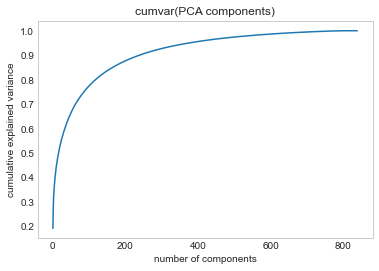

In [9]:
S = StandardScaler()
flat_train = S.fit_transform(flat_train) 

pca = PCA().fit(flat_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('cumvar(PCA components)')
plt.show()


Conserving ~300 features from the images already allows to keep 90% of the original dataset variance. We choose then to perform a PCA with 300 components. So the final samples have 300 features

In [10]:
# also possible to specify variance explained ration instead of number of components 
# e.g. nb_components = 0.9 means conserving 90% of original variance

pca = PCA(n_components = 300)

pca_train = pca.fit_transform(flat_train)

print("dataset final shape : ", pca_train.shape)

flat_test = S.transform(flat_test)
pca_test = pca.transform(flat_test)

dataset final shape :  (840, 300)


### Inverse PCA (300 features) transform and 3D Visualization

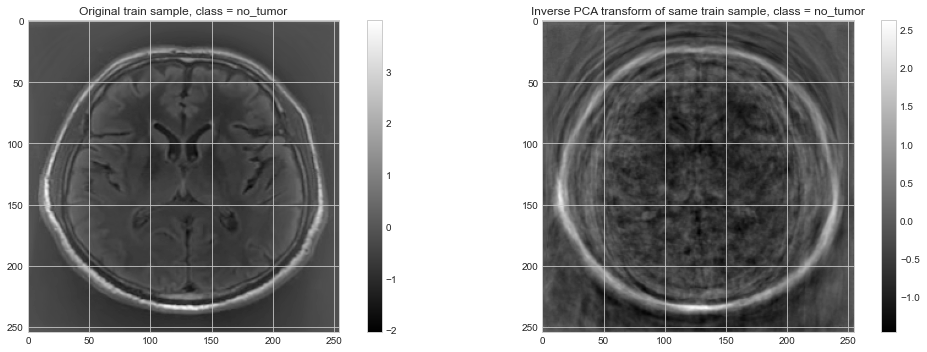

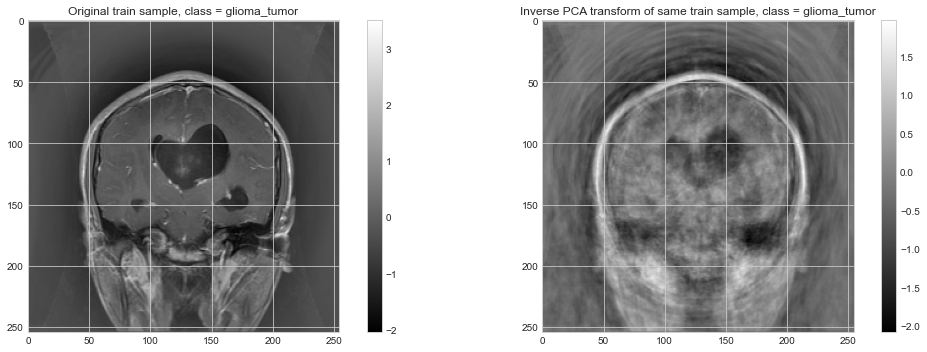

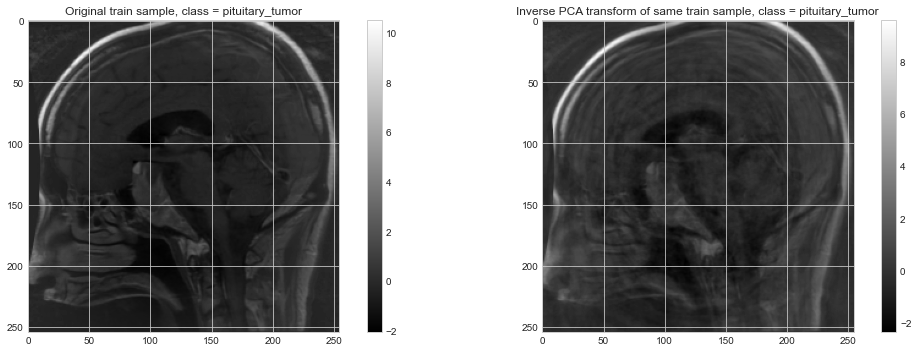

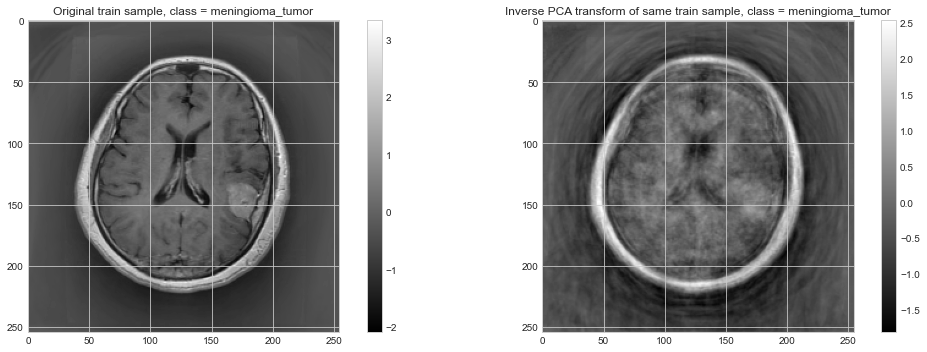

In [11]:
# comparing original samples and their PCA inverser transform
def compare(label = 'no_tumor'):
    #all index of a certain class 
    clas = class_map[label]
    ind = np.where(y_train == clas)[0]
    rand_ind = np.random.choice(ind)

    #PCA inverse transform
    X_inv = pca.inverse_transform(pca_train)

    #original sample
    x_orig = flat_train[rand_ind].reshape(255,255)
    #pca inv transform sample
    x_pca = X_inv[rand_ind].reshape(255,255)

    #plot comparison between original and pca inverse transform
    fig, axs = plt.subplots(1,2, figsize = (15, 5))
    im1 = axs[0].imshow(x_orig, cmap = 'gray')
    axs[0].set_title('Original train sample, class = {}'.format(label))
    plt.colorbar(im1, ax = axs[0])

    im2 = axs[1].imshow(x_pca, cmap = 'gray')
    axs[1].set_title('Inverse PCA transform of same train sample, class = {}'.format(label))
    plt.colorbar(im2, ax = axs[1])
    fig.tight_layout()
    plt.show()
    
for key in class_map.keys():
    compare(label = key)

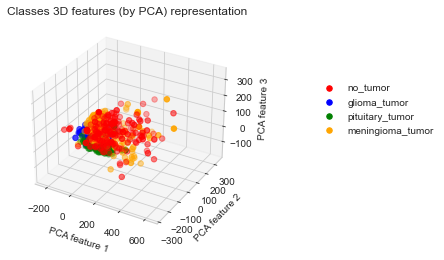

In [12]:
scatter_x = pca_train[:, 0]
scatter_y = pca_train[:, 1]
scatter_z = pca_train[:, 2]
group = y_train

cdict = {0: 'red', 1: 'blue', 2: 'green', 3 : "orange"}
identification = {v : k for k,v in class_map.items()}


plt.figure()
ax = plt.axes(projection = '3d')
plt.grid()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter3D(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = identification[g], s = 30)
ax.legend(bbox_to_anchor =(1.95,0.75))
plt.xlabel("PCA feature 1")
plt.ylabel("PCA feature 2")
ax.set_zlabel("PCA feature 3")
plt.title("Classes 3D features (by PCA) representation")
plt.show()

The 3D representation in PCA space seems to show poor separability of the samples. We will then test the SVM algorithm on it to check this out. 

## F - Statistic

The F-Statistic is the result of the ANOVA F-test, which measures how much relevant each pixel is. This relevance is represented by the interclass-intraclass variances ratio.

In [13]:
from sklearn.feature_selection import f_classif

f, pval = f_classif(flat_train, y_train)
rankings['f'] = np.argsort(f)[::-1]
print(rankings['f'])

[56650 30681 56395 ... 33961 29372 29627]


/!\ Plot testing /!\

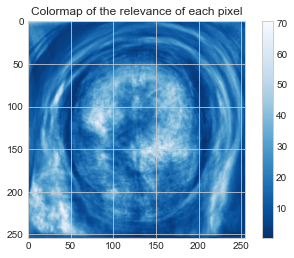

In [14]:
plt.figure()
plt.imshow(f.reshape(255,255), cmap='Blues_r')
plt.colorbar()
plt.title("Colormap of the relevance of each pixel")
plt.show()

### Mutual Information

Estimate mutual information between a feature and the target : higher is the mutual info, higher is the dependeency with the target class. 

WARNING : Computationally expensive

In [15]:
from sklearn.feature_selection import mutual_info_classif
mi_selected_features = mutual_info_classif(flat_train, y_train)

rankings['mi'] = np.argsort(mi_selected_features)[::-1]

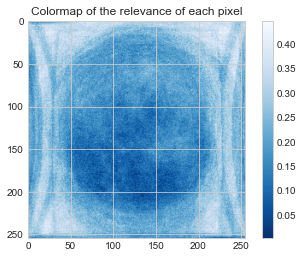

In [16]:
plt.figure()
plt.imshow(mi_selected_features.reshape(255,255), cmap='Blues_r')
plt.colorbar()
plt.title("Colormap of the relevance of each pixel")
plt.show()

## Split Dataset and Test with SVM

We will have to distinguish pca feature selection from f-stat and mutual info as pca doesn't provide a ranking of the relevant features, moreover it can create a number of features less or equal to the number of samples.

In [17]:
algos = ['f', 'mi']  # feature selection algorithms
ks = [30, 100, 200, 300]    

In [18]:
# Flatten the dataset

X_train = train_img.reshape((train_img.shape[0], 255*255))
#y_train = train_labels
X_test = test_img.reshape((test_img.shape[0], 255*255))
#y_test = test_labels
print(X_train.shape)
print(X_test.shape)

(2870, 65025)
(394, 65025)


### SVM classifier

Some theory about this classifier is presented in the next lab (4).

In [19]:
from sklearn import svm

SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')

SVMaccuracy = pd.DataFrame(index = ks, columns = algos)
SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')

for algo in algos:
    print(algo)
    for nfeats in ks:
        
        feats = rankings[algo][:nfeats]

        SVM.fit(
            flat_train[:, feats], y_train,
        ) 
        y_pred = SVM.predict(flat_test[:, feats])
        cm1 = confusion_matrix(y_test, y_pred)
        svm_accuracy = np.sum(np.diag(cm1))/np.sum(cm1)
        SVMaccuracy.loc[ks, algo] = svm_accuracy

        print(f"SVM accuracy {nfeats} features: ", svm_accuracy)

print("pca")
pca_SVM_acc = []
for nfeats in ks:
    SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')
    SVM.fit(
            pca_train[:, :nfeats], y_train,
        ) 
    y_pred = SVM.predict(pca_test[:, :nfeats])
    cm1 = confusion_matrix(y_test, y_pred)
    svm_accuracy = np.sum(np.diag(cm1))/np.sum(cm1)
    pca_SVM_acc.append(svm_accuracy)

    print(f"SVM accuracy {nfeats} features: ", svm_accuracy)


f
SVM accuracy 30 features:  0.5833333333333334
SVM accuracy 100 features:  0.6166666666666667
SVM accuracy 200 features:  0.6194444444444445
SVM accuracy 300 features:  0.6305555555555555
mi
SVM accuracy 30 features:  0.6361111111111111
SVM accuracy 100 features:  0.6416666666666667
SVM accuracy 200 features:  0.6388888888888888
SVM accuracy 300 features:  0.6444444444444445
pca
SVM accuracy 30 features:  0.7777777777777778
SVM accuracy 100 features:  0.8
SVM accuracy 200 features:  0.8
SVM accuracy 300 features:  0.8027777777777778


### Accuracy Plot for SVM
Accuracy of support vector machine model trained on different no of features and different feature selection algorithm.

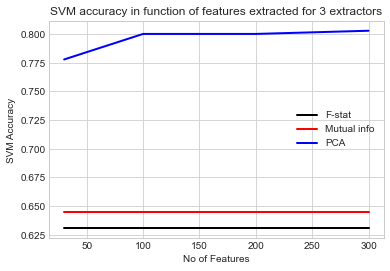

In [20]:
fig = plt.figure()
ax = plt.axes()
x = ks
y3 = SVMaccuracy.f.values.tolist()
y4 = SVMaccuracy.mi.values.tolist() 
y5 = pca_SVM_acc

plt.plot(x, y3, '-k', linewidth=2, label = "F-stat") 
plt.plot(x, y4, '-r', linewidth=2, label = "Mutual info")
plt.plot(x, y5, '-b', linewidth=2, label = "PCA")
plt.legend()

plt.xlabel("No of Features")
plt.ylabel("SVM Accuracy")
plt.title("SVM accuracy in function of features extracted for 3 extractors")

plt.show()


Up to 300 extracted features, PCA is better by a considerable margin than the other extractors in terms of SVM accuracy.